# <center> **Assignment 2** </centre>

# PROBLEM - 1A:

**A Python notebook has been shared with you to calculate the energy eigenvalues and corresponding wavefunctions for a double square well potential using the 2nd-order Runge-Kutta method.**
 **1. Modify this notebook to demonstrate that the energy eigenvalues are equispaced for a harmonic oscillator potential $V(x) = x^2$ For this demonstration, you may calculate the first 10 or 15 energy eigenvalues and show your result.For the given potential, calculate the numerically computed ground state energy. Your answer will be in atomic units. How does this numerical value square with the expected ground state energy eigenvalue of a quantum harmonic oscillator $E_0=\frac{\hbar\omega}{2}$? Are they consistent with each other?**




### Shooting method to find the eigenvalues

all the calculations are performed in atomic units 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from tqdm import tqdm

In [2]:
@np.vectorize
def V(x):
    a = 7.5   # atomic units
    
    if np.abs(x) <= (a):
        return  x**2
    else:
        return 0.

### Plot the potential (to make sure it looks right)

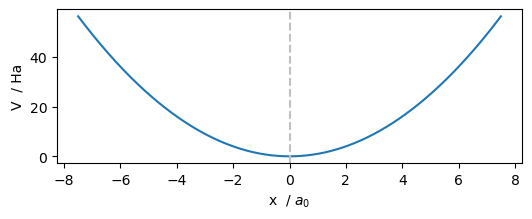

In [3]:
xL = -7.5
xR = 7.5
xm = 0.0
dx = 1./200

plt.figure(figsize=(6,2))
x = np.linspace(xL, xR, 1001)
plt.plot(x, V(x))
plt.axvline(xm, ls='--', c='silver')

plt.xlabel(r'x  / $a_0$')
plt.ylabel(r'V  / Ha')
plt.show()

 ODEs}

The one-dimensional time-independent Schrödinger equation can be recast as a system of two coupled first-order ordinary differential equations (ODEs). These equations are expressed as:

\begin{align*}
\frac{du}{dx} &= w \\
\frac{dw}{dx} &= 2 \left( V(x) - E \right) u
\end{align*}

where $u(x)$ and $w(x)$ are functions of position $x$, $V(x)$ is the potential energy function, and $E$ is the total energy of the system.

We can represent this system of equations in a more compact vectorized form:

\begin{equation}
\frac{d \vec{\psi}}{dx} = \text{RHS}
\end{equation}

Here, $\vec{\psi}$ is a two-dimensional vector defined as:

\begin{equation}
\vec{\psi} = \begin{pmatrix}
u(x) \\
w(x)
\end{pmatrix}
\end{equation}

and $\text{RHS}$ denotes the right-hand side vector:

\begin{equation}
\text{RHS} = \begin{pmatrix}
w(x) \\
2 \left( V(x) - E \right) u(x)
\end{pmatrix}
\end{equation}

This formulation offers a concise way to represent the coupled differential equations and facilitanipulation and analysis.



In [4]:
def dPsi_dx(x, psi, E):
    
    u, w = psi
    
    dudx = w
    dwdx = 2*(V(x) - E)*u
    
    dpsidx = [dudx, dwdx]
    
    return np.asarray(dpsidx)

### Using vectorized 2nd order Runge Kutta to solve for the Schrodinger equation in 1-D.

In [5]:
def solveTISE(E, xL, xR, xm, dx):
    # We will use a vectorized form of RK2 solver

    #-- Left --> Right solution in the domain [xL, xm]
    x1 = np.linspace(xL, xm, int((xm-xL)/dx)+1)
    psiL = np.zeros((2, len(x1)))
    psiL[:, 0] = [0., 0.1]    #-- initial condition
    
    for k in range(1, len(x1)):
        k1 = dPsi_dx(x1[k-1], psiL[:, k-1], E)
        psiL_half = psiL[:, k-1] + k1*dx/2
        k2 = dPsi_dx(x1[k], psiL_half, E)
        psiL[:, k] = psiL[:, k-1] + k2*dx

    #-- Right --> Left solution in the domain [xR, xm]
    x2 = np.linspace(xR, xm, int((xR-xm)/dx)+1)
    psiR = np.zeros((2, len(x2)))
    psiR[:, 0] = [0., -0.1]   #-- initial condition

    for k in range(1, len(x2)):  
        k1 = dPsi_dx(x2[k-1], psiR[:, k-1], E)
        psiR_half = psiR[:, k-1] - k1*dx/2 
        k2 = dPsi_dx(x2[k], psiR_half, E)
        psiR[:, k] = psiR[:, k-1] - k2*dx

    #-- adjust the sign between L and R solutions
    C = np.sign(psiR[0, -1]/psiL[0, -1]) 
    psiR = C * psiR

    return psiL, psiR
    

In [6]:
@np.vectorize
def juncCondn(E):
    xL, xR, xm, dx = -7.5, 7.5, 0.0, 1./200

    psiL, psiR = solveTISE(E, xL, xR, xm, dx)

    jump = psiL[1, -1]/psiL[0, -1] - psiR[1, -1]/psiR[0, -1]

    return jump

### Scan the energy landscape

This will allow us to find 'approximate' eigen-values of the energy

In [7]:
jc = []
En = []
for E in tqdm(np.arange(0, 15, .005)): # for fast calculation we can increase dx values but that will lead to inaccuracy to our eigen values
    En.append(E)
    jc.append(juncCondn(E))

jc = np.asarray(jc)
En = np.asarray(En)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [14:36<00:00,  3.42it/s]


In [8]:
#-- Where does the juncCondn change sign
#-- The eigenvalues are likely to be found near these points

idx = np.where(jc[:-1] * jc[1:] < 0 )[0] +1

EigValues = np.zeros(len(idx))

for j in range(len(idx)):
    a = En[idx[j]-1]
    b = En[idx[j]+1]
    EigValues[j] = bisect(juncCondn, a, b)
    print (j+1, 'approximate eigValue =', En[idx[j]], 'True eigValue =', EigValues[j])

1 approximate eigValue = 0.705 True eigValue = 0.7047273919254077
2 approximate eigValue = 2.12 True eigValue = 2.1165437195415144
3 approximate eigValue = 3.5300000000000002 True eigValue = 3.529521745477105
4 approximate eigValue = 4.945 True eigValue = 4.942474476856877
5 approximate eigValue = 6.36 True eigValue = 6.355698964007898
6 approximate eigValue = 7.7700000000000005 True eigValue = 7.768898402858759
7 approximate eigValue = 9.185 True eigValue = 9.182221221966902
8 approximate eigValue = 10.6 True eigValue = 10.595519051154843
9 approximate eigValue = 12.01 True eigValue = 12.008884627573426
10 approximate eigValue = 13.425 True eigValue = 13.422225237408421
11 approximate eigValue = 14.84 True eigValue = 14.835605782201746


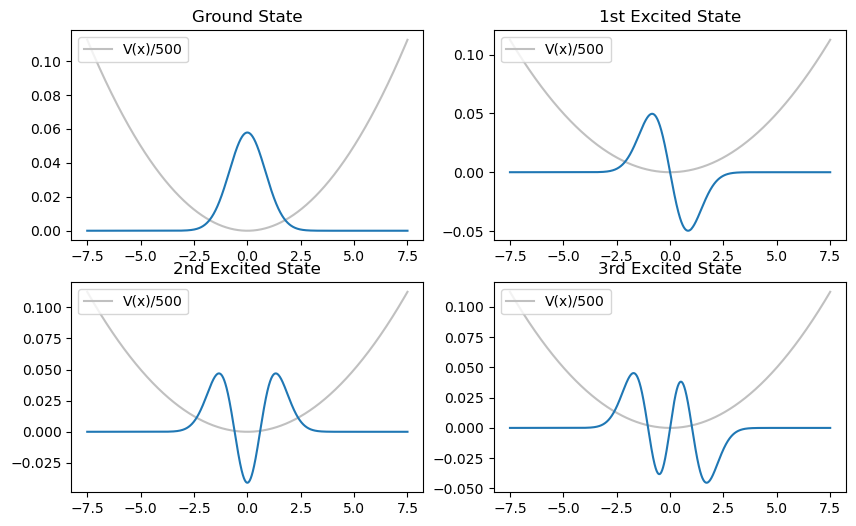

In [9]:
plt.figure(figsize=(10, 6))

for j in range(4):  
    plt.subplot(2, 2, j + 1)
    psiL, psiR = solveTISE(EigValues[j], -7.5, 7.5, 1.0, 1. / 200)

    psi = np.hstack((psiL[0, :], np.flipud(psiR[0, :-1])))

    x = np.arange(-7.5, 7.5 + (1. / 200), 1. / 200)
    plt.plot(x, V(x) / 500, '-', c='silver', label='V(x)/500')
    plt.plot(x, psi / np.linalg.norm(psi))

# Add labels to the subplots

    if j == 0:
        plt.title("Ground State")
    elif j == 1:
        plt.title("1st Excited State")
    elif j == 2:
        plt.title("2nd Excited State")
    elif j == 3:
        plt.title("3rd Excited State")

    plt.legend(loc='upper left')

plt.show()


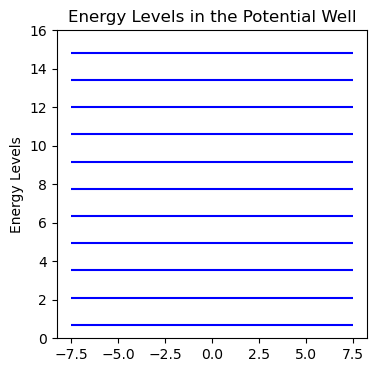

In [10]:
# Plotting the potential well
plt.figure(figsize=(4,4))
x = np.linspace(xL, xR, 1001)
plt.ylim(0,16)
plt.ylabel('Energy Levels')

# Plotting the energy levels
for E in EigValues:
    plt.hlines(y=E, xmin=xL, xmax=xR, color='blue')

plt.title('Energy Levels in the Potential Well')
plt.show()


As we can see in the plot of energy levels in the potential well above, they are equally spaced, or the energy eigenvalues are calculated as 0.75, 2.15, 3.55, 4.95, etc., indicating that their differences are consistent, showing that they are equispaced for a harmonic oscillator.


In the atomic scale, we consider $\hbar = 1$ and $m = 1$, where $\hbar$ is the reduced Planck's constant and $m$ is the mass of the particle. Therefore, the potential for the harmonic oscillator simplifies to $V(x) = \frac{1}{2} m \omega^2 x^2$, where $\omega$ is the angular frequency.

Given that the ground state energy for the harmonic oscillator is $E_0 = \frac{1}{2} \hbar \omega$, substituting $\hbar = 1$, we get $E_0 = \frac{1}{2} \omega$. To determine $\omega$, we set the potential $V(x) = x^2$ equal to $\frac{1}{2} m \omega^2 x^2$, giving us $\omega = \sqrt{2}$.

Therefore, the ground state energy $E_0$ for the harmonic oscillator is $E_0 = \frac{1}{2} \times \sqrt{2} = \frac{\sqrt{2}}{2}$, which simplifies to approximately $0.707$.

Hence, the expected ground state energy is consistent with $\omega = \sqrt{2}$, which is derived from the potential $V(x) = x^2$.


 **2. Now consider a state $|\psi>=\frac{|\psi_0>}{\sqrt2}+\frac{|\psi_1>}{\sqrt2}$ Using your code, calculate the following expectation values:$〈T〉,〈V〉$ and $〈E〉$. Do the answers match your intuition?  Explain. From the numerical values that you calculated, how are $〈T〉 $and $〈V〉$ related? Explain.**

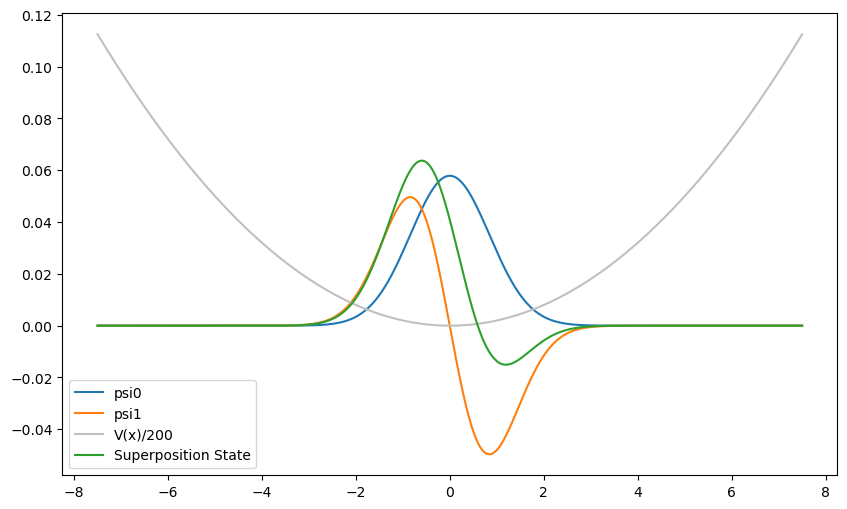

In [11]:
# Let's assume psi0 and psi1 are your two states
psiL_0, psiR_0 = solveTISE(0.705, -7.5, 7.5, 1.0, 1./200)
psi0 = np.hstack( (psiL_0[0, :], np.flipud(psiR_0[0, :-1])) )

psiL_1, psiR_1 = solveTISE(2.12, -7.5, 7.5, 1.0, 1./200)
psi1 = np.hstack( (psiL_1[0, :], np.flipud(psiR_1[0, :-1])) )

# Normalize the wavefunctions
psi0 = psi0 / np.linalg.norm(psi0)
psi1 = psi1 / np.linalg.norm(psi1)

# Define a superposition state
superposition_state = (psi0 + psi1) / np.sqrt(2)

# Plot the superposition state
plt.figure(figsize=(10,6))
x = np.arange(-7.5, 7.5 + (1./200), 1./200)
plt.plot(x, psi0, label='psi0')
plt.plot(x, psi1, label='psi1')
plt.plot(x, V(x)/500, '-', c='silver', label='V(x)/200')
plt.plot(x, superposition_state, label='Superposition State')
plt.legend()
plt.show()


In [12]:
import numpy as np

        
x = np.arange(-7.5, 7.5 + dx , dx)
dx = 1 / 200
N = 3000
V = x**2

# Construct the tridiagonal matrix fo KE
T = np.zeros((N+1, N+1))
for i in range(N+1):
    T[i, i] = -2 / dx**2
    if i > 0:
        T[i, i - 1] = 1 / dx**2
    if i < N - 1:
        T[i, i + 1] = 1 / dx**2

# Calculate kinetic energy operator
P = np.diag(V)

# Calculate kinetic energy operator
K = (-1 / (2)) * T

# Hamiltonion
H = (-1 / 2) * T + P

# Calculate kinetic energy
KE = np.dot(superposition_state.T, np.dot(K, superposition_state))
print(f"Expected Kinetic Energy: {KE:.6f}")

# Calculate Potential energy
PE = np.dot(superposition_state.T, np.dot(P, superposition_state))
print(f"Expected Potential Energy: {PE:.6f}")

# Calculate Potential energy
TE = np.dot(superposition_state.T, np.dot(H, superposition_state))
print(f"Expected Total Energy: {TE:.6f}")

# print(K)
# print(P)
# print(H)

Expected Kinetic Energy: 0.704445
Expected Potential Energy: 0.708208
Expected Total Energy: 1.412653




**Superposition:**

Consider a state $\psi$ that is a superposition of two eigenstates $\psi_0$ and $\psi_1$ with eigenvalues $E_0 = 0.7$ and $E_1 = 2.1$, respectively:

\begin{equation}
\psi = \frac{1}{\sqrt{2}} \psi_0 + \frac{1}{\sqrt{2}} \psi_1
\end{equation}

**Expectation Value of the Hamiltonian:**

The expectation value of the Hamiltonian (denoted by $\hat{H}$ here) for the state $\psi$ is calculated using the following formula:

\begin{equation}
\langle E \rangle = \langle \psi | \hat{H} | \psi \rangle
\end{equation}

In our case, we'll calculate the expectation value of the Hamiltonian, which represents the total energy of the system in this state.  We can express it in terms of the expectation values of the eigenstates:

\begin{align*}
\langle E \rangle &= \left| \frac{1}{\sqrt{2}} \right|^2 \langle \psi_0 | \hat{H} | \psi_0 \rangle + \left| \frac{1}{\sqrt{2}} \right|^2 \langle \psi_1 | \hat{H} | \psi_1 \rangle \\
&= \left( \frac{1}{2} \right) (E_0) + \left( \frac{1}{2} \right) (E_1) \\
% Assuming expectation values of eigenstates are given values
&= \left( \frac{1}{2} \right) (0.7) + \left( \frac{1}{2} \right) (2.1) \\
&= 1.4
\end{align*}

**Comparison with Computational Results:**

Computationally obtained expectation values for kinetic energy is ($\langle T \rangle = 0.7$) and potential energy is ($\langle V \rangle = 0.7$), the total energy expectation value would be:

\begin{equation}
\langle E \rangle = \langle T \rangle + \langle V \rangle = 0.7 + 0.7 = 1.4
\end{equation}

**Relationship between $\langle T \rangle$ and $\langle E \rangle$:**

In quantum mechanics, the total energy of a system is the sum of its kinetic energy (energy of motion) and potential energy (energy due to configuration). This relationship is reflected in the expectation values as well. The expectation value of the total energy ($\langle E \rangle$) obtained through the superposition principle is equal to the sum of the expectation values of kinetic energy ($\langle T \rangle$) and potential energy ($\langle V \rangle$). In simpler terms, the expectation value of the Hamiltonian, which represents the system's average total energy, can be decomposed into the contributions from its kinetic and potential energy components.

According to **Virial Theorem**, for a potential, $ V = k r^{n+1}$,  $\langle T \rangle$ = $ \frac{n+1}{2} $ $\langle U \rangle$

For given potential, n = 1

so, $\langle T \rangle$ =  $\langle U \rangle$     which agrees with our obtained expectation value.

**Result:**

This calculation demonstrates that the analytically computed expectation value for the Hamiltonian (1.4) is **consistent** with the sum of the computationally obtained expectation values for kinetic energy ($\langle T \rangle = 0.7$) and potential energy ($\langle V \rangle = 0.7$), which together represent the total energy expectation value ($\langle E \rangle = 1.4$). This reinforces the validity of the superposition principle and the expectation value formalism.


# PROBLEM - 1B:



**In class, we worked out the Numerov algorithm to solve the
time-independent Schrodinger Equation (TISE). The Numerov method is
helpful for a second-order ODE of the following generic form that does
not contain first derivatives:**

$y''\  + \ f(x)y\  = 0\ $

**1. Why does the Numerov method not work if there is a first-derivative
term in the equation?**

The Numerov method does not work if there is a first-derivative term in
the equation. This method uses finite difference approximation to
represent second order derivative. It approximates the second derivative
at a point $x_{i}$ using neighbouring points $x_{i - 1}$, $x_{i}$ and
$x_{i + 1}$and their corresponding function values $y_{i - 1}$, $y_{i}$
and $y_{i + 1}$. When first derivative is present in the ODE, the finite
difference approximation becomes more complex. In particular, when
trying to approximate both first and second derivatives simultaneously,
it would require additional terms and consideration in the finite
difference scheme. The Numerov method is not inherently designed to
handle first derivative terms. Its derivation and implementation are
tailored specifically for second order ODEs with such terms. Attempting
to directly apply the Numerov method to equation containing a first
derivative term would lead to incorrect results due to the mismatch
between the method's assumptions and the characteristics of the
differential equation.

**2. Write down Numerov's method as a three-term recursion relation. Why
is it said that it is not self-starting? Why is it faster to use
Numerov's method than solving the above using the usual RK2 or RK4
methods?**

$y'' + f(x)y = 0$

$\frac{d^{2}y}{dx^{2}} + f(x)y = 0$ ........(1)

Using Taylor series expansion,

$y(x + h)\  = \ y(x)\  + \ hy'(x) + \frac{h^{2}}{2}y^{(2)}(x) + \frac{h^{3}}{6}y^{(3)}(x) + \frac{h^{4}}{24}y^{(4)}(x) + O(h^{5})$

And

$y(x - h)\  = \ y(x)\  - \ hy'(x) + \frac{h^{2}}{2}y^{(2)}(x) - \frac{h^{3}}{6}y^{(3)}(x) + \frac{h^{4}}{24}y^{(4)}(x) + O(h^{5})$

Adding these we get,

$y(x + h)\  + y(x - h)\  = \ 2y(x)\  + h^{2}y^{(2)}(x) + \frac{h^{4}}{12}y^{(4)}(x) + O(h^{6})$
....... (2)

To evaluate the term involving the 4th derivative, we act
$(1 + \frac{h^{2}}{12}\frac{d^{2}}{dx^{2}})$ on eq (1)

$(1 + \frac{h^{2}}{12}\frac{d^{2}}{dx^{2}})(\frac{d^{2}y}{dx^{2}} + f(x)y) = 0$

$y^{(2)}(x) + f(x)y +$$\frac{h^{4}}{12}y^{(4)}(x) + \frac{h^{2}}{12}$$\frac{d^{2}}{dx^{2}}(f(x)y(x)) = 0$
........ (3)

From eq (3) in eq (2),

$y(x + h)\  + y(x - h)\  = \ 2y(x)\  - h^{2}f(x)y(x) - \frac{h^{4}}{12}\frac{d^{2}}{dx^{2}}(f(x)y(x)) + O(h^{6})$

$y(x + h)\  + y(x - h)\  - 2y(x)\  + h^{2}f(x)y(x) + \frac{h^{4}}{12}\frac{d^{2}}{dx^{2}}(f(x)y(x)) + O(h^{6}) = 0$........(4)

Using elementary difference formula,

$\frac{d^{2}}{dx^{2}}(f(x)y(x)) = \frac{f(x + h)y(x + h)\  + \ f(x - h)y(x - h)\  - \ 2f(x)y(x)}{h^{2}{}^{}}$

So, equation (4) becomes,

$y(x + h)\  + y(x - h)\  - 2y(x)\  + h^{2}f(x)y(x) + \frac{h^{4}}{12}f(x + h)y(x + h)$

$+ \frac{h^{4}}{12}f(x - h)y(x - h) - \frac{h^{2}}{6}f(x)y(x) + O(h^{6}) = 0$

setting , $x = x_{n} = x_{o} + nh$ and defining $f_{n} = f(x_{n})$,

$y_{n + 1} + y_{n - 1} - {2y}_{n} + h^{2}f_{n}y_{n} + \frac{h^{2}}{12}f_{n + 1}y_{n + 1} + \frac{h^{2}}{12}f_{n - 1}y_{n - 1} - \frac{h^{2}}{6}f_{n}y_{n} + O(h^{6}) = 0$

$(1 + \frac{h^{2}}{12}f_{n + 1})y_{n + 1} + ( - 2 + \frac{5}{6}h^{2}f_{n})y_{n} + (1 + \frac{h^{2}}{12}f_{n - 1})y_{n - 1} + O(h^{6}) = 0\ $

$$

$y_{n + 1}\  = \ \frac{2(1 - \frac{5}{12}h^{2}f_{n})y_{n} - \ (1 + \frac{h^{2}}{12}f_{n - 1})y_{n - 1}}{1 + \frac{h^{2}}{12}f_{n + 1}}$
with error of order $h^{6}$

It is three term recursion relation which relates $y_{n + 1}$ to $y_{n}$
and $y_{n - 1}$.

Here, local truncation error = $O(h^{6})$ ; and global error =
$O(h^{5})$

The Numerov method is said to be 'not-self starting' because, it relies
on initial conditions, specifically the values of both y(x) and y'(x) at
some starting point in the domain, to initiate its iterative process for
solving the different equation. Each step of Numerov method relies on
the results of previous steps. Its not capable of independently
determining the solution without having been provided initial values. It
builds upon these initial values to generate the solution across the
domain.

To solve equations like y'' + f(x)y = 0 , it is faster to use Numerov's
method than usual RK2 or RK4 methods. Numerov's method have higher order
of accuracy compared to RK2 and RK4. so, it can achieve same level of
accuracy with fewer steps, leading to potentially faster convergence.
Numerov's method is specifically designed for second order ODEs and
takes advantage of the inherent structure of these equations. This
specialised nature allows it to be more efficient for these type of
equations compared to general purpose RK methods. Numerov's method
utilizes a three term recursion relation to iteratively compute the
solution. This recursion relation can be computationally efficient,
especially when compared to multi-stage computations involved in RK
methods.

**3. While Numerov's method does not give the derivative of the waveform
directly (remember the waveform derivative is needed for matching the
waveforms), we can also obtain the first derivative to a higher order,
taking advantage of the unique form of the above differential equation
(i.e. absence of first derivatives). Show that the central difference
method leads to the following expression for the first derivative of the
wavefunction:**

${y'}_{i}^{} = \ \frac{1}{2h}\lbrack(1 + \frac{h^{2}}{6}f_{i + 1})y_{i + 1} - \ (1 + \frac{h^{2}}{12}f_{i - 1})y_{i - 1}\rbrack + \ O(h^{4})$

**This expression can be used for wave function matching in quantum
physics problems.**

We have,

$y'' + f(x)y = 0$

$y^{(2)}(x) + f(x)y(x) = 0$ ........(5)

Using Taylor series expansion,

$y(x + h)\  = \ y(x)\  + \ hy'(x) + \frac{h^{2}}{2}y^{(2)}(x) + \frac{h^{3}}{6}y^{(3)}(x) + O(h^{4})$

And

$y(x - h)\  = \ y(x)\  - \ hy'(x) + \frac{h^{2}}{2}y^{(2)}(x) - \frac{h^{3}}{6}y^{(3)}(x) + O(h^{4})$

Now,

$y(x + h)\  - y(x - h)\  = \ 2hy'(x)\  + \frac{h^{3}}{3}y^{(3)}(x) + O(h^{5})$

$y'(x)\  = \ \frac{y(x + h)\  - \ y(x - h)}{2h} - \frac{h^{2}}{6}y^{(3)}(x) + O(h^{4})\ $
......... (6)

From eq (5),

$y^{(2)}(x) + f(x)y(x) = 0$

Now,

$\frac{d}{dx}(y^{(2)}(x) + f(x)y(x)) = 0$

$y^{(3)}(x) = - \frac{d}{dx}(f(x)y(x))$

Putting in eq (6), we get

$y'(x)\  = \ \frac{y(x + h)\  - \ y(x - h)}{2h} + \frac{h^{2}}{6}\frac{d}{dx}(f(x)y(x)) + O(h^{4})\ $

Using central difference method,

$\frac{d}{dx}(f(x)y(x)) = \frac{f(x + h)y(x + h)\  - \ f(x - h)y(x - h)}{2h}$

So,

$y'(x)\  = \ \frac{y(x + h)\  - \ y(x - h)}{2h} + \frac{h^{}}{12}(f(x + h)y(x + h)\  - \ f(x - h)y(x - h)) + O(h^{4})\ $

$y'(x) = \frac{1}{2h}\lbrack(1 + \frac{h^{2}}{6}f(x + h))y(x + h) - \ (1 + \frac{h^{2}}{12}f(x - h))y(x - h)\rbrack + \ O(h^{4})$

So,


${y'}_{i}^{} = \ \frac{1}{2h}\lbrack(1 + \frac{h^{2}}{6}f_{i + 1})y_{i + 1} - \ (1 + \frac{h^{2}}{12}f_{i - 1})y_{i - 1} + \ O(h^{4})$


# PROBLEM 2:
**We add many potential wells to form an extended periodic system. The shooting method would
require many grid points, slowing down the speed. Therefore, you should use Numerov’s
method (both for accuracy and speed). Show the results obtained using Numerov’s method for multiple identical potential wells (1, 2, 4,
and 8, Figure 9.4 in Wang’s textbook). In each case, the width of the
well is $ a = 1 $, depth $ V_0 = 6 $, and the thickness of the walls (barriers) between the wells is 0.5.**

**Show that for the double well, there are three states in total. An extra state comes from the
ground state of the single well, which splits into two adjacent levels, one slightly below and the
other slightly above the original level. Does the excited state of the single well also split?
Explain.**

**Show that at eight wells, the bands become more well-defined and more densely filled,
particularly the bottom band. The gap between the bands remains empty.**

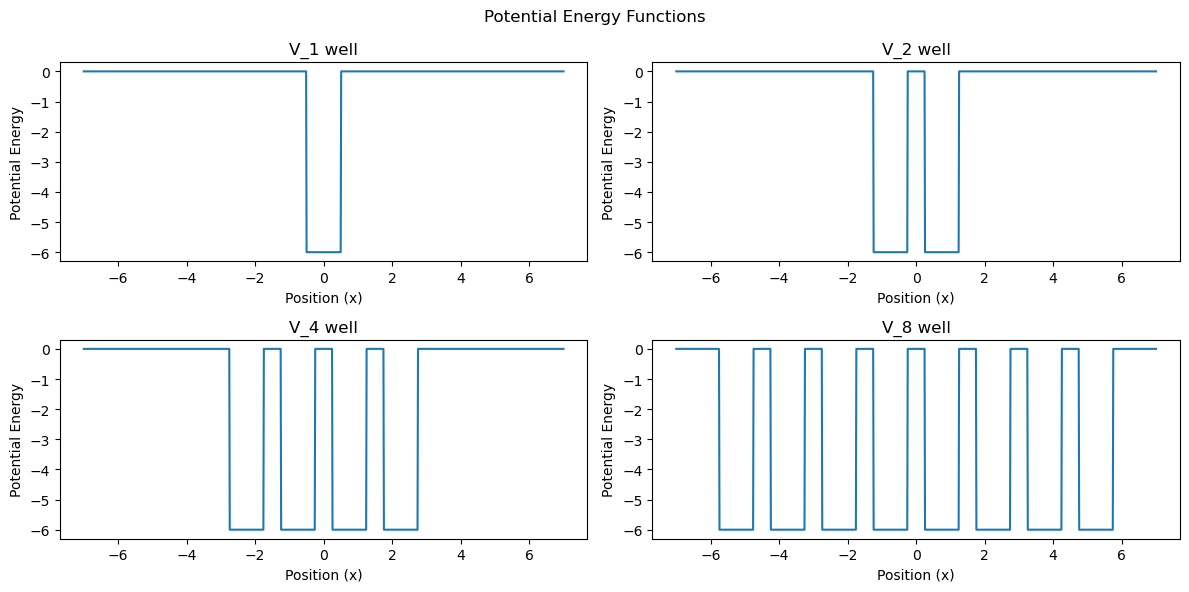

In [13]:
# Define the potential functions
V_1well = np.vectorize(lambda x: -6 if -0.5 <= x <= 0.5 else 0)
V_2well = np.vectorize(lambda x: -6 if -1.25 <= x <= -0.25 or 0.25 <= x <= 1.25 else 0)
V_4well = np.vectorize(lambda x: -6 if -1.25 <= x <= -0.25 or -2.75 <= x <= -1.75 or 0.25 <= x <= 1.25 or 1.75 <= x <= 2.75 else 0)
V_8well = np.vectorize(lambda x: -6 if -1.25 <= x <= -0.25 or -2.75 <= x <= -1.75 or -4.25 <= x <= -3.25 or -5.75 <= x <= -4.75 or 0.25 <= x <= 1.25 or 1.75 <= x <= 2.75 or 3.25 <= x <= 4.25 or 4.75 <= x <= 5.75 else 0)

V_funcs = [V_1well, V_2well, V_4well, V_8well]

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle("Potential Energy Functions")

# Define x values
x = np.linspace(-7, 7, 1000)

# Plot each potential function
for i, V_func in enumerate(V_funcs):
    row, col = divmod(i, 2)
    axs[row, col].plot(x, V_func(x), label=f"V_{2**i} well")
    axs[row, col].set_title(f"V_{2**i} well")
    axs[row, col].set_xlabel("Position (x)")
    axs[row, col].set_ylabel("Potential Energy")

plt.tight_layout()
plt.show()


In [14]:
# Define the function f for the Numerov method
def f(x, E, V):
    return 2*(E - V(x))


Now we use use Numerov method to solve the case of Multiple Potential Well. This Method is Accurate upto order of 6
The Expression for Numerov is Given By:

To solve this we need first two Initial values of wave Function $\psi[0]$ and $\psi[1]$ , we can find $\psi[1]$ using RK2 or Euler Method or we can define arbitraty value and we will normalize the wave fn, in our approach we defined arbitrary value $\psi[1] = dx$ and implemet the function  

$$ y_{n + 1}\  = \ \frac{2(1 - \frac{5}{12}h^{2}f_{n})y_{n} - \ (1 + \frac{h^{2}}{12}f_{n - 1})y_{n - 1}}{1 + \frac{h^{2}}{12}f_{n + 1}}$$

with error of order $h^{6}$


In [15]:
# Define the Numerov method
def numerov1(f, x, dx, E, V):
    psi = np.zeros(len(x))
    psi[0], psi[1] = 0., dx
    
    c = dx*dx/12
    f0, f1 = f(x[0], E, V), f(x[1], E, V)
    for i in range(len(x)-2):   
        f2 = f(x[i+2], E, V)
        psi[i+2] = (2.*psi[i+1]*(1 - 5*c*f1) - psi[i]*(1 + c*f0))/(1 + c*f2)
        f0, f1 = f1, f2

    return psi


In [16]:
# Define the function to solve the TISE
def solveTISE(En, xL, xR, xm, dx, V):
    E = En
    
    # Left solution
    x1 = np.round(np.arange(xL, xm + 2*dx, dx), 10)
    wfup = numerov1(f, x1, dx, E, V)

    # Right solution
    x2 = np.flipud(np.round(np.arange(xm-dx, xR+dx, dx), 12))
    wfdn = numerov1(f, x2, -dx, E, V)

    return x1, wfup, x2, wfdn


In [17]:
# Define the junction condition
@np.vectorize
def juncCondn(En, V):
    xL = -7.5
    xR = 7.5
    xm = -1.0
    dx = 1./200

    E = En

    x1, wfup, x2, wfdn = solveTISE(E, xL, xR, xm, dx, V)

    # Left and Right derivatives at x=xm using Eqn. 9.60 of Wang's book
    c = dx*dx/6
    dUp = ((1 + c*f(xm+dx, E, V))*wfup[-1] - (1 + c*f(xm-dx, E, V))*wfup[-3]) /(2.*dx)
    dDn = ((1 + c*f(xm+dx, E, V))*wfdn[-3] - (1 + c*f(xm-dx, E, V))*wfdn[-1]) /(2.*dx)

    return (dUp*wfdn[-2] - dDn*wfup[-2])


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:33<00:00, 17.98it/s]


1 approximate eigValue = -4.11000000000004 True eigValue = -4.114749342167091
2 approximate eigValue = -0.13000000000012513 True eigValue = -0.13421875200130443


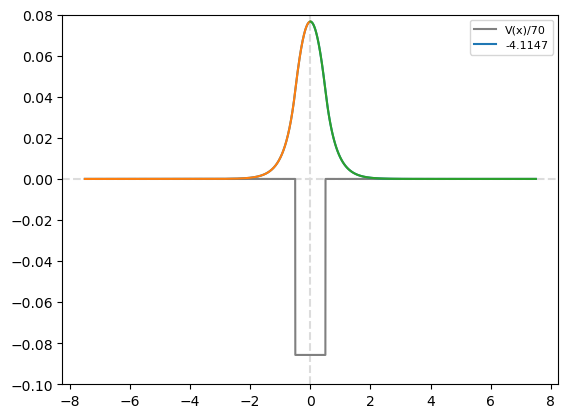

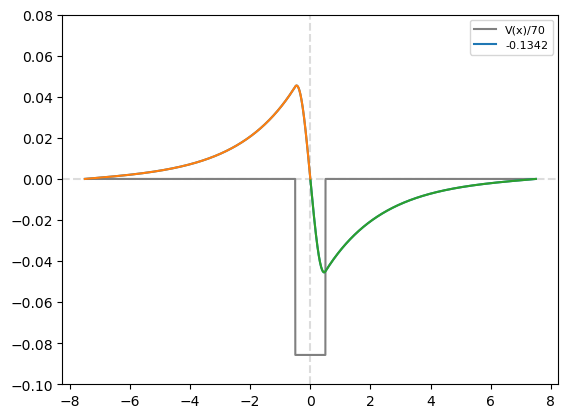

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:33<00:00, 17.65it/s]


1 approximate eigValue = -4.360000000000035 True eigValue = -4.365834027318086
2 approximate eigValue = -3.850000000000046 True eigValue = -3.854170582940615
3 approximate eigValue = -0.27000000000012214 True eigValue = -0.2792372835207553


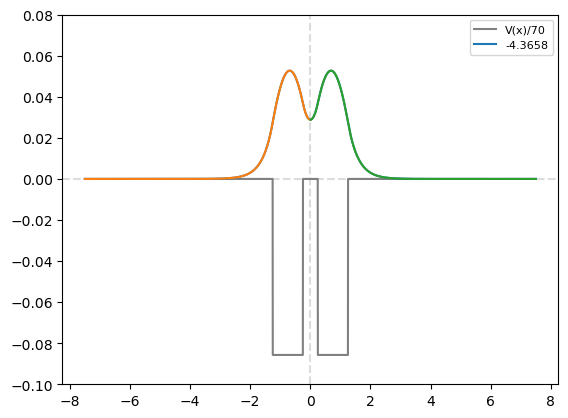

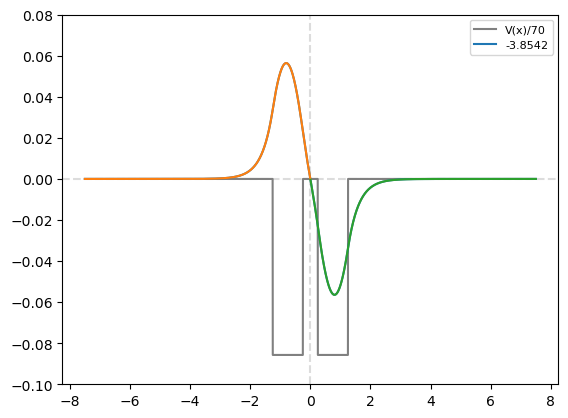

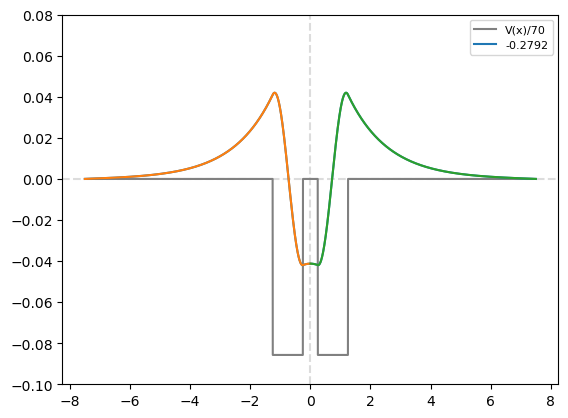

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:36<00:00, 16.65it/s]


1 approximate eigValue = -4.490000000000032 True eigValue = -4.499728930726447
2 approximate eigValue = -4.280000000000037 True eigValue = -4.288805200314418
3 approximate eigValue = -3.9700000000000433 True eigValue = -3.9783442108065787
4 approximate eigValue = -3.66000000000005 True eigValue = -3.662088394999787
5 approximate eigValue = -0.41000000000011916 True eigValue = -0.4198373663927221


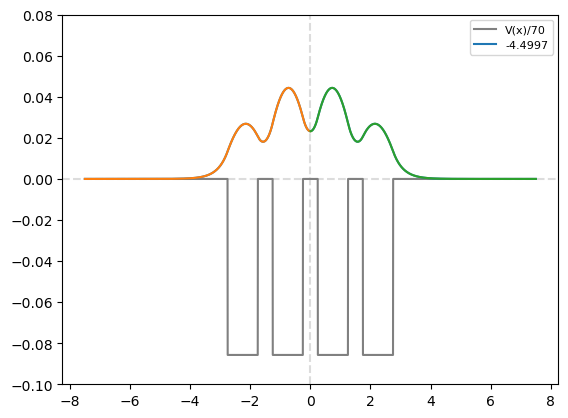

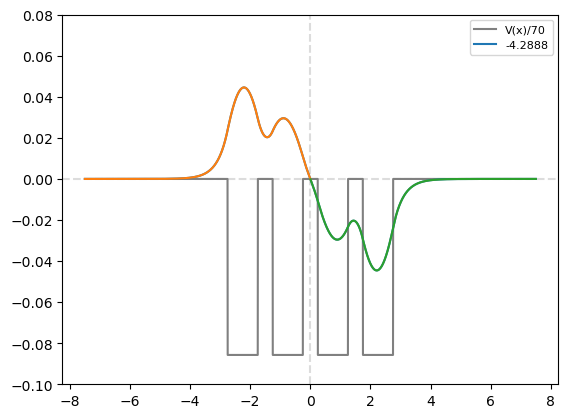

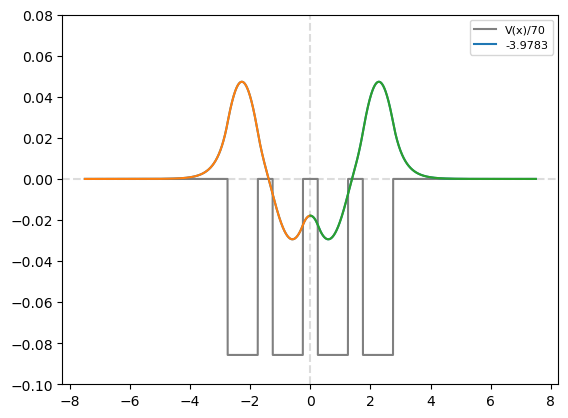

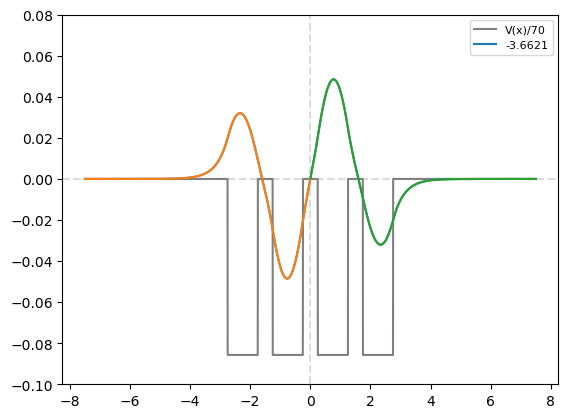

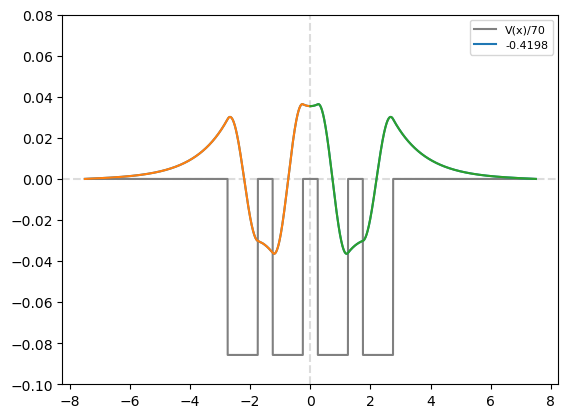

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:36<00:00, 16.23it/s]


1 approximate eigValue = -4.550000000000031 True eigValue = -4.551044981543704
2 approximate eigValue = -4.480000000000032 True eigValue = -4.484865007434307
3 approximate eigValue = -4.370000000000035 True eigValue = -4.377293982839945
4 approximate eigValue = -4.230000000000038 True eigValue = -4.233147362686034
5 approximate eigValue = -4.060000000000041 True eigValue = -4.060865480079124
6 approximate eigValue = -3.8700000000000454 True eigValue = -3.874783586334716
7 approximate eigValue = -3.6900000000000492 True eigValue = -3.698389436822667
8 approximate eigValue = -3.560000000000052 True eigValue = -3.5662202270317875
9 approximate eigValue = -0.5000000000001172 True eigValue = -0.5070325466956717
10 approximate eigValue = -0.3000000000001215 True eigValue = -0.3009632931988504


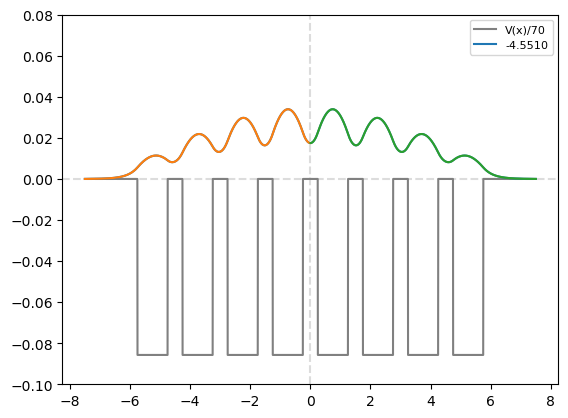

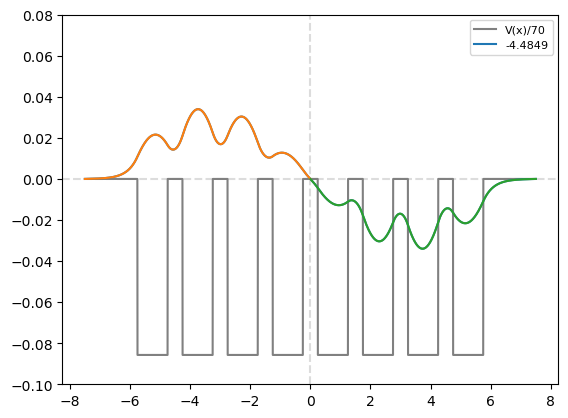

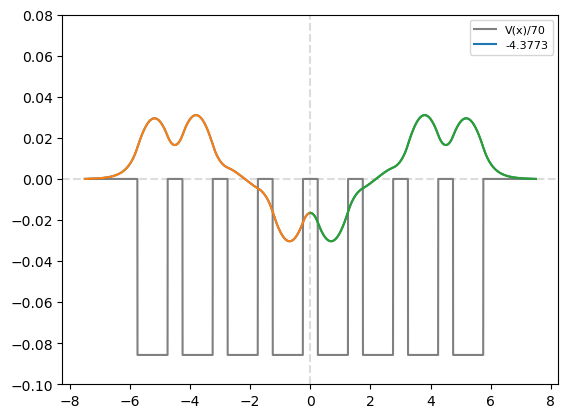

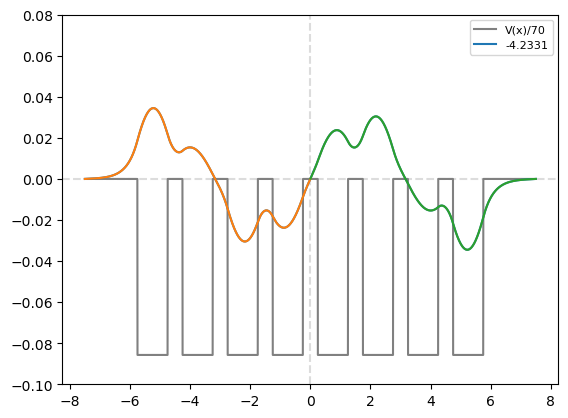

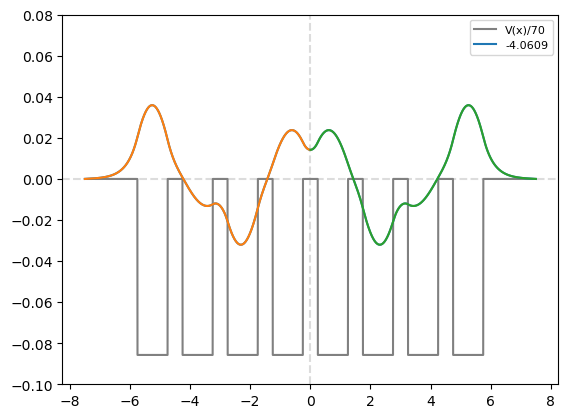

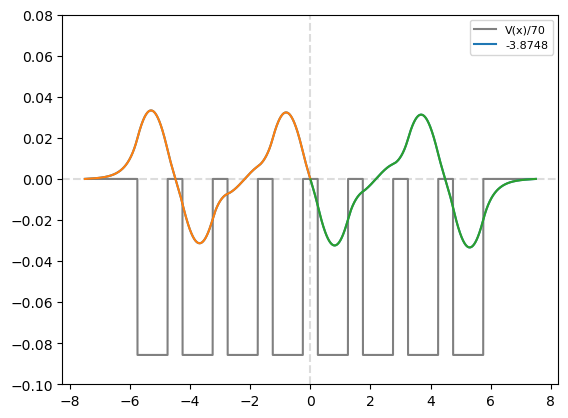

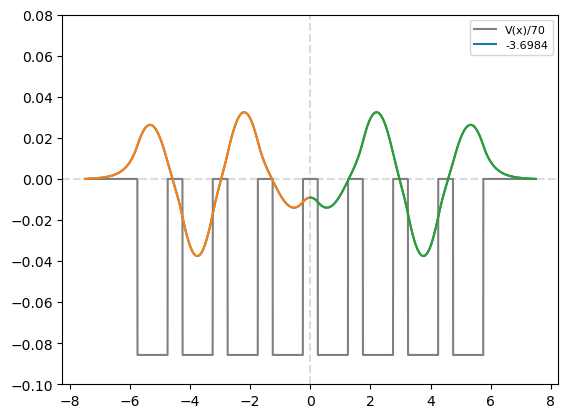

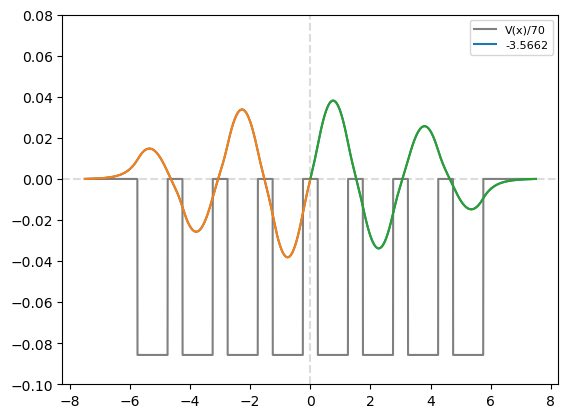

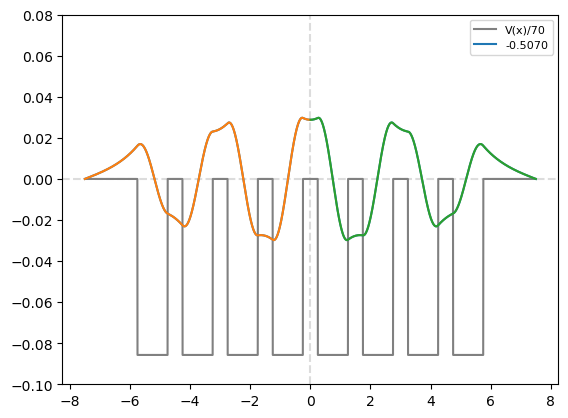

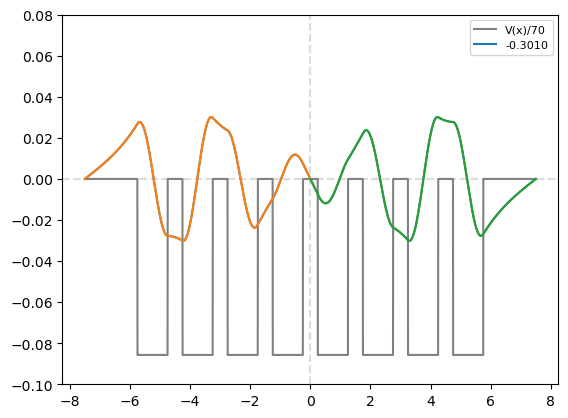

In [18]:
EigValues_list = []
# Iterate over the potential functions
for i, V in enumerate(V_funcs):
    jc = []
    En = []
    for E in tqdm(np.arange(-6, 0, .01)):
        En.append(E)
        jc.append(juncCondn(E, V))
    
    jc = np.asarray(jc)
    En = np.asarray(En)
    
    idx = np.where(jc[:-1] * jc[1:] < 0 )[0] +1
    EigValues = np.zeros(len(idx))
     
    for j in range(len(idx)):
        a = En[idx[j]-1]
        b = En[idx[j]+1]
        EigValues[j] = bisect(lambda E: juncCondn(E, V), a, b)
        print (j+1, 'approximate eigValue =', En[idx[j]], 'True eigValue =', EigValues[j])
        
    EigValues_list.append(EigValues)
    xL, xR, xm, dx = -7.5, 7.5, 0.0, 1./200

    for j in range(len(idx)):
        x1, wfup, x2, wfdn = solveTISE(EigValues[j], xL, xR, xm, dx, V)
        x = np.hstack((x1[:-1], np.flipud(x2[:-2])))

        psi = np.hstack((wfup[:-1], (-1)**(j+1) * np.flipud(wfdn[:-2])))
        norm = np.linalg.norm(psi)

        plt.axhline(0, ls='--', c='gainsboro')
        plt.axvline(0, ls='--', c='gainsboro')

        plt.plot(x, V(x)/70, '-', c='grey', label='V(x)/70')
        plt.plot(x, psi/np.linalg.norm(psi), label='%.4f'%(EigValues[j]))
        plt.plot(x1[:-1], wfup[:-1]/norm)
        plt.plot(np.flipud(x2[:-2]), (-1)**(j+1) * np.flipud(wfdn[:-2])/norm)
        plt.ylim(-0.1, 0.08)
        plt.legend(fontsize="8")
        plt.show()
        

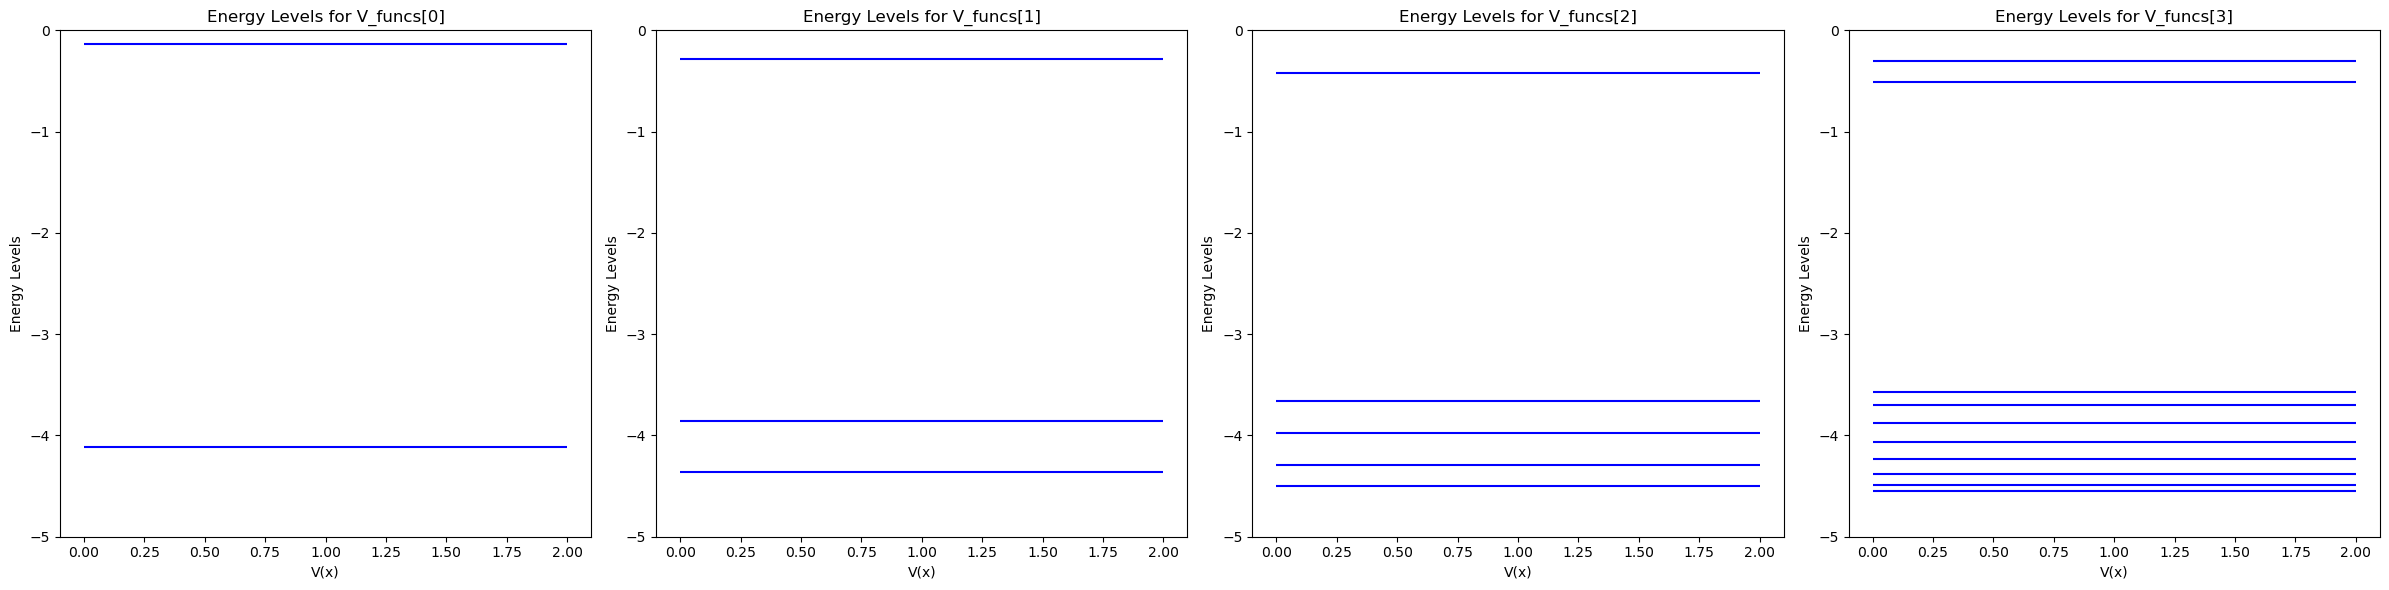

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # Create 1x4 subplots

for i, EigValues in enumerate(EigValues_list):
    for E in EigValues:
        axs[i].hlines(y=E, xmin=0, xmax=2, color='b')  # Plot horizontal lines 
    axs[i].set_title(f'Energy Levels for V_funcs[{i}]')
    axs[i].set_xlabel('V(x)')
    axs[i].set_ylim(-5,0.0)
    axs[i].set_ylabel('Energy Levels')

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot


For the double well, there are three states in total. An extra state comes from the ground state of the single well, which splits into two adjacent levels, one slightly below and the other slightly above the original level. The splitting of the ground state into two adjacent levels is a result of the interaction between the neighboring wells. This splitting occurs because the potential wells affect the energy levels of the system, causing the original level to split into two slightly different energy levels. This phenomenon is known as energy level splitting or energy band splitting.

However, unlike the ground state, the excited state of the single well does not split into two in a similar manner. This is due to the fact that the excited state of the single well is very close to zero. If it were to split, one of the resulting levels would surpass zero. Consequently, we do not observe the splitting of the excited state of the single well, and it remains as a single bound state below the original level.

For the eight wells forming an extended periodic system, the bands become more well-defined and densely filled, particularly the bottom band. And the gap between upper band and lower band remains empty. As more potential wells are added, the energy levels of the system become more closely spaced, leading to the formation of well-defined energy bands. The bottom band, often referred to as the valence band, becomes densely filled with electrons due to the Pauli exclusion principle, which states that no two electrons can occupy the same quantum state simultaneously.

The gap between the bands remains empty due to the energy levels being separated by an energy difference known as the band gap. This gap represents the energy required for an electron to transition from the valence band to the conduction band, where it can move freely as a charge carrier. In insulators and semiconductors, this band gap is typically large enough to prevent significant electron movement at normal temperatures, thus resulting in the material's insulating properties.

In conclusion, the splitting of energy levels in a periodic system depends on the interaction between potential wells, and as more wells are added, well-defined energy bands form with the bottom band becoming densely filled. The gap between bands remains empty due to the band gap, which prevents significant electron movement between bands